# MEMO Assignment
Andrea De Carlo and Pooya Torabi

In [25]:
import torch
import torchvision

In [26]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, torchvision.tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [27]:
import boto3
from PIL import ImageOps, Image
from io import BytesIO
from pathlib import Path
from torch.utils.data import Dataset


class S3ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            label, key = self.instances[idx]

            # Download image from S3
            # response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
            # img_bytes = response["Body"]._raw_stream.data

            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)
            # img_bytes = response["Body"]._raw_stream.data

            # Open image with PIL
            img = Image.open(img_bytes).convert("RGB")

            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)
        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, self.class_to_idx[label]

In [28]:
pre_process_mean = [0.485, 0.456, 0.406]
pre_process_std = [0.229, 0.224, 0.225]
normalize = torchvision.transforms.Normalize(mean=pre_process_mean, std=pre_process_std)
resnet_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [29]:
# Dataset: ImageNet-A
# https://github.com/hendrycks/natural-adv-examples
from dotenv import load_dotenv
from os import getenv

load_dotenv()
local_env = getenv('local')

# https://github.com/hendrycks/natural-adv-examples/blob/master/eval.py
thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2,
                     14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1,
                     27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1,
                     39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13,
                     51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1,
                     63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1,
                     75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1,
                     87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1,
                     99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1,
                     110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1,
                     121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1,
                     132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1,
                     143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1,
                     154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1,
                     165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1,
                     176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1,
                     187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1,
                     198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1,
                     209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1,
                     220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1,
                     231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1,
                     242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1,
                     253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1,
                     264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1,
                     275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1,
                     286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1,
                     297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50,
                     308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1,
                     319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1,
                     330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1,
                     341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1,
                     352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1,
                     363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1,
                     374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1,
                     385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1,
                     396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1,
                     407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82,
                     418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85,
                     429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1,
                     440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1,
                     451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92,
                     462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95,
                     473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96,
                     484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1,
                     495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1,
                     506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1,
                     516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1,
                     527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1,
                     537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1,
                     547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1,
                     557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1,
                     567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1,
                     577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1,
                     588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1,
                     599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1,
                     609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1,
                     619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1,
                     629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1,
                     640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1,
                     650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1,
                     661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1,
                     672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1,
                     682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1,
                     692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1,
                     703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1,
                     714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1,
                     725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1,
                     736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1,
                     746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1,
                     756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144,
                     766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1,
                     776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1,
                     786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1,
                     796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1,
                     806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158,
                     816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1,
                     826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163,
                     836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165,
                     846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1,
                     856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1,
                     866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1,
                     877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1,
                     887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1,
                     897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1,
                     907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1,
                     917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1,
                     928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183,
                     938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186,
                     948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190,
                     958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1,
                     969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1,
                     979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199,
                     989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
indices_in_1k = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]

if local_env:
    imagenet_a_directory = 'datasets/imagenet-a'
    imagenet_a = torchvision.datasets.ImageFolder(root=imagenet_a_directory, transform=resnet_preprocess)
else:
    imagenet_a_directory = "OfficeHomeDataset_10072016/Real World"
    imagenet_a = S3ImageFolder(root=imagenet_a_directory, transform=resnet_preprocess)

In [30]:
import numpy as np
import torch.nn as nn


class MarginalEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs):
        # compute mean entropy
        logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
        avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
        min_real = torch.finfo(avg_logits.dtype).min
        avg_logits = torch.clamp(avg_logits, min=min_real)
        mean_entropy = -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits
        return mean_entropy


loss_fn = MarginalEntropy()

In [64]:
# augmix from original paper

def augmix(x_orig):
    x_orig = preaugment(x_orig)
    x_orig = torchvision.transforms.ToPILImage()(x_orig)
    x_processed = preprocess(x_orig)
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    mix = torch.zeros_like(x_processed)
    for i in range(3):
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):
            x_aug = np.random.choice(augmentations)(x_aug)
        mix += w[i] * preprocess(x_aug)
    mix = m * x_processed + (1 - m) * mix
    return mix


def autocontrast(pil_img, level=None):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, level=None):
    return ImageOps.equalize(pil_img)


def rotate(pil_img, level):
    degrees = int_parameter(rand_lvl(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR, fillcolor=128)


def solarize(pil_img, level):
    level = int_parameter(rand_lvl(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, level, 0, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def shear_y(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, 0, level, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def translate_x(pil_img, level):
    level = int_parameter(rand_lvl(level), 224 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def translate_y(pil_img, level):
    level = int_parameter(rand_lvl(level), 224 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, 0, 0, 1, level), resample=Image.BILINEAR, fillcolor=128)


def posterize(pil_img, level):
    level = int_parameter(rand_lvl(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def rand_lvl(n):
    return np.random.uniform(low=0.1, high=n)


augmentations = [
    autocontrast,
    equalize,
    lambda x: rotate(x, 1),
    lambda x: solarize(x, 1),
    lambda x: shear_x(x, 1),
    lambda x: shear_y(x, 1),
    lambda x: translate_x(x, 1),
    lambda x: translate_y(x, 1),
    lambda x: posterize(x, 1),
]

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    normalize
])
preaugment = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
])

In [65]:
def memo_tta(pretrained_model, sample, BN_prior_strength=None):
    # "only one gradient step per test point" as per paper
    epochs_for_adaptation = 1
    learning_rate = 0.00001
    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)

    augmented_samples = []
    for _ in range(64):
        augmented_sample = augmix(sample)
        augmented_samples.append(augmented_sample)
    augmented_samples = torch.stack(augmented_samples)

    pretrained_model.eval()

    if BN_prior_strength is not None:
        nn.BatchNorm2d.prior = float(BN_prior_strength) / float(BN_prior_strength + 1)

    for epoch in range(epochs_for_adaptation):
        output_distributions = pretrained_model(augmented_samples)
        output_distributions = output_distributions[:, indices_in_1k]

        loss, _ = loss_fn(output_distributions)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if BN_prior_strength is not None:
        nn.BatchNorm2d.prior = 1
    return pretrained_model

In [66]:
def test_single(adapted_model, sample, BN_prior_strength=None):
    adapted_model.eval()

    if BN_prior_strength is not None:
        nn.BatchNorm2d.prior = float(BN_prior_strength) / float(BN_prior_strength + 1)

    sample = sample.unsqueeze(0)  # create a mini-batch as expected by the resnet model

    with torch.no_grad():
        outputs = adapted_model(sample.cuda())
        outputs = outputs[:, indices_in_1k]
        _, predicted = outputs.max(1)
    prediction = predicted.item()

    if BN_prior_strength is not None:
        nn.BatchNorm2d.prior = 1
    return prediction

In [67]:
fresh_pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


# https://github.com/bethgelab/robustness/blob/main/robusta/batchnorm/bn.py#L175
def modified_bn_forward(self, input):
    est_mean = torch.zeros(self.running_mean.shape, device=self.running_mean.device)
    est_var = torch.ones(self.running_var.shape, device=self.running_var.device)
    nn.functional.batch_norm(input, est_mean, est_var, None, None, True, 1.0, self.eps)
    running_mean = self.prior * self.running_mean + (1 - self.prior) * est_mean
    running_var = self.prior * self.running_var + (1 - self.prior) * est_var
    return nn.functional.batch_norm(input, running_mean, running_var, self.weight, self.bias, False, 0, self.eps)


def get_fresh_pretrained_model(BN_prior_strength=None):
    pretrained_model = fresh_pretrained_model
    pretrained_model = pretrained_model.cuda()
    # in case multiple GPUs are available, this will try to utilize by Data Parallelism
    pretrained_model = nn.DataParallel(pretrained_model)

    if BN_prior_strength is not None:
        nn.BatchNorm2d.prior = float(BN_prior_strength) / float(BN_prior_strength + 1)
        nn.BatchNorm2d.forward = modified_bn_forward

    return pretrained_model

Using cache found in C:\Users\pooya/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\pooya\miniconda3\envs\Memo_DL2024\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pooya\miniconda3\envs\Memo_DL2024\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
def experiment_adaptation_on_dataset(adaptation_method, **kwargs):
    BN_prior_strength = kwargs.get('BN_prior_strength', None)

    correct_predictions = 0
    i = 0
    for sample in imagenet_a:
        input_image = sample[0]
        input_label = sample[1]

        pretrained_model = get_fresh_pretrained_model(BN_prior_strength)
        adapted_model = adaptation_method(pretrained_model, input_image, **kwargs)

        # inference phase
        prediction = test_single(adapted_model, input_image, BN_prior_strength)
        correctness = 1 if prediction == input_label else 0
        correct_predictions += correctness

        i += 1
        if i == 150:
            break
    top1_accuracy = correct_predictions / len(imagenet_a)

    return top1_accuracy

In [74]:
# implementation of: test time adaptation via MEMO, without single sample batch norm
top1_accuracy = experiment_adaptation_on_dataset(adaptation_method=memo_tta)

print(f"top-1 accuracy for memo base implementation: {top1_accuracy}")

top-1 accuracy for memo base implementation: 0.0006666666666666666


In [75]:
# implementation of: test time adaptation via MEMO, with single sample batch norm
top1_accuracy = experiment_adaptation_on_dataset(adaptation_method=memo_tta, BN_prior_strength=16)

print(f"top-1 accuracy for memo base implementation: {top1_accuracy}")

top-1 accuracy for memo base implementation: 0.0012


### Augmentation function: Random Patch Hiding
idea from this paper: https://arxiv.org/pdf/1704.04232 and https://openreview.net/pdf?id=SHMi1b7sjXk#page=6.63

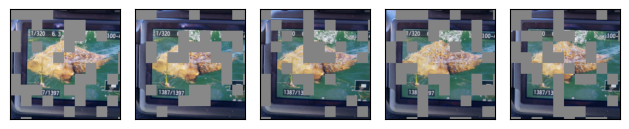

In [76]:
import random


def random_hide_patch(img):
    # get width and height of the image
    _, H, W = img.shape

    patch_size = int(min(H, W) * 0.1)  # Example: 10% of the shorter side of the image

    # Create a copy of the image to avoid modifying the original image
    masked_img = img.clone()

    hide_prob = 0.3

    for x in range(0, W, patch_size):
        for y in range(0, H, patch_size):
            x_end = min(W, x + patch_size)
            y_end = min(H, y + patch_size)
            choose_to_hide = random.uniform(0, 1)
            if choose_to_hide <= hide_prob:
                masked_img[:, y:y_end, x:x_end] = 0

    return masked_img


random_patched_img = []
for i in range(5):
    random_patched_img.append(random_hide_patch(imagenet_a[0][0]))

plot(random_patched_img)

In [78]:
from torch.distributions import Categorical


def tta_with_random_hided_patch(pretrained_model, sample):
    epochs_for_adaptation = 3
    learning_rate = 0.00001
    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)

    augmented_samples = []
    for _ in range(64):
        augmented_sample = random_hide_patch(sample)
        augmented_samples.append(augmented_sample)
    augmented_samples = torch.stack(augmented_samples)

    pretrained_model.eval()

    # augmentation selection
    with torch.no_grad():
        output_distributions = pretrained_model(augmented_samples)
        output_distributions = output_distributions[:, indices_in_1k]
        output_distributions = torch.softmax(output_distributions, dim=-1)

        output_entropies = []
        for output_distribution in output_distributions:
            output_entropy = Categorical(probs=output_distribution).entropy()
            output_entropies.append(output_entropy)
        output_entropies = torch.stack(output_entropies).cpu()

        first_quartile = np.percentile(output_entropies, 25)
        mean = output_entropies.mean().item()
        augmentation_selection_threshold = min(first_quartile, mean)

        augmentation_idx_to_keep = []
        for idx, output_entropy in enumerate(output_entropies):
            if output_entropy >= augmentation_selection_threshold:
                augmentation_idx_to_keep.append(idx)

        augmented_samples = augmented_samples[augmentation_idx_to_keep]

    # adaptation phase
    for epoch in range(epochs_for_adaptation):
        output_distributions = pretrained_model(augmented_samples)
        output_distributions = output_distributions[:, indices_in_1k]

        loss, _ = loss_fn(output_distributions)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return pretrained_model

In [79]:
top1_accuracy = experiment_adaptation_on_dataset(adaptation_method=tta_with_random_hided_patch)

print(f"top-1 accuracy for Random Patch Hiding: {top1_accuracy}")

top-1 accuracy for Random Patch Hiding: 0.00013333333333333334
